In [1]:
import os
import sys
import json
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import glob
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#Replace the data directory here
data_dir = 'assets/demo_assets/'
data_files = glob.glob(data_dir+"/*.wav")

In [3]:
#Calling the API for audio embedding, use the right port number in the below CURL command
audio_len = 10
i = 0
embeddings = []
for file in data_files:
    print('Sending CURL command # '+str(i)+'\n')
    curl_string = str('curl -F "audio=@'+file+'" -XPOST http://127.0.0.1:5000/model/predict > out_'+str(i)+'.json')
    print(curl_string)
    os.system(curl_string)
    current_embedding = open('out_'+str(i)+'.json', 'r')
    current_embedding = json.load(current_embedding)
    test = np.asarray(current_embedding['result'])
    if(test.shape[0]>=audio_len):
        test = test[0:audio_len,:]
        test = test.flatten()
        embeddings.append(test)
        print("Embedding complete and saved to numpy array! Removing the json file.. \n")
    else:
        print("Audio length < 10 seconds.. skipping this file")
    os.system('rm -f '+'out_'+str(i)+'.json')
    i = i+1

Sending CURL command # 0

curl -F "audio=@assets/demo_assets/jazz_guitar.wav" -XPOST http://127.0.0.1:5000/model/predict > out_0.json
Embedding complete and saved to numpy array! Removing the json file.. 

Sending CURL command # 1

curl -F "audio=@assets/demo_assets/birds2.wav" -XPOST http://127.0.0.1:5000/model/predict > out_1.json
Embedding complete and saved to numpy array! Removing the json file.. 

Sending CURL command # 2

curl -F "audio=@assets/demo_assets/birds1.wav" -XPOST http://127.0.0.1:5000/model/predict > out_2.json
Embedding complete and saved to numpy array! Removing the json file.. 

Sending CURL command # 3

curl -F "audio=@assets/demo_assets/gunshots.wav" -XPOST http://127.0.0.1:5000/model/predict > out_3.json
Embedding complete and saved to numpy array! Removing the json file.. 

Sending CURL command # 4

curl -F "audio=@assets/demo_assets/train.wav" -XPOST http://127.0.0.1:5000/model/predict > out_4.json
Embedding complete and saved to numpy array! Removing the jso

In [4]:
#Flattening the embeddings from 10X128 to 1x1280
embeddings_norm = [x.reshape(1,-1) for x in embeddings]

In [5]:
#Computing cosine similarity
n = len(embeddings)
dist = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        dist[i,j] = float(cosine_similarity(embeddings_norm[i],embeddings_norm[j]))

In [6]:
#Labels for the graph/plot
labels = [filen.replace(data_dir,'') for filen in data_files]
labels = [filen.replace('.wav','') for filen in labels]

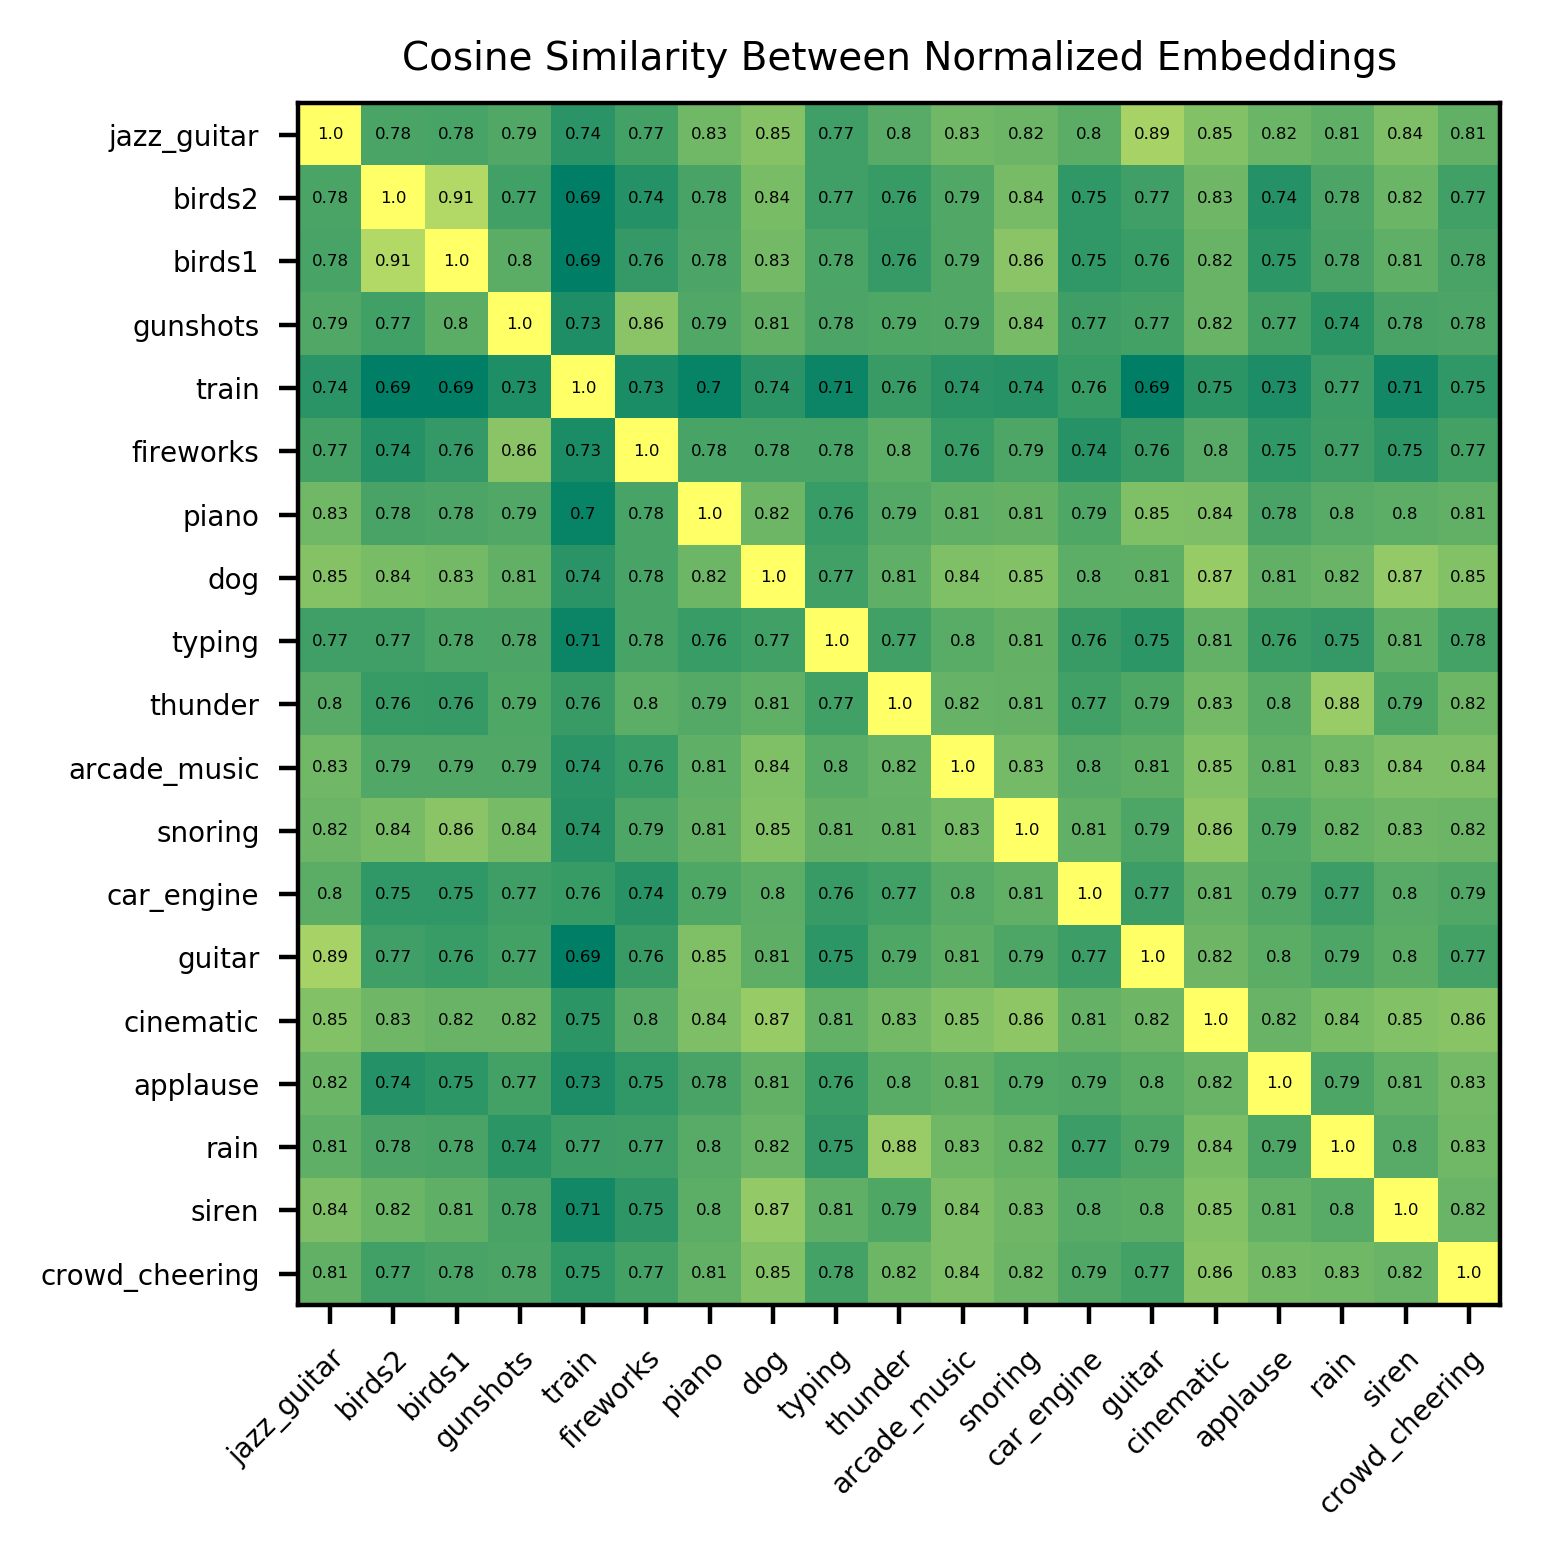

In [9]:
#Plotting the cosine similarity scores
fig, ax = plt.subplots()
im = ax.imshow(dist,cmap="summer")

# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(labels,size = 5)
ax.set_yticklabels(labels,size = 5)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(labels)):
    for j in range(len(labels)):
        text = ax.text(j, i, np.round(dist[i,j], decimals=2),
                       ha="center", va="center", color="black",size=3)

ax.set_title("Cosine Similarity Between Normalized Embeddings",size = 7)
fig.tight_layout()

matplotlib.rcParams['figure.dpi']= 400
matplotlib.rc("savefig", dpi=400)

plt.savefig('heatmap.png')
plt.show()